<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

This notebook searches the parameter space to create the best possible architecture for our autoencoder and saves the file into a Google Storage Bucket.

In [1]:
!rm -rf autoencoders_census
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

Cloning into 'autoencoders_census'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 211 (delta 52), reused 0 (delta 0), pack-reused 123
Receiving objects: 100% (211/211), 7.35 MiB | 16.01 MiB/s, done.
Resolving deltas: 100% (118/118), done.
/content/autoencoders_census


In [2]:
from google.colab import auth

# Login using the account that has access to the Google project
# in order to access the resources for the project
auth.authenticate_user()

In [3]:
# This code imports the DataTransformer object from
# the notebook pandas2vector.ipynb
!pip install -q import_ipynb keras-tuner
import import_ipynb
from pandas2vector import Table2Vector
from data_loader import DataLoader
from autoencoder import AutoencoderModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.2 MB/s eta 0:00:00
importing Jupyter notebook from pandas2vector.ipynb
importing Jupyter notebook from data_loader.ipynb
importing Jupyter notebook from autoencoder.ipynb


# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from matplotlib.offsetbox import TransformedBbox

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed

In [7]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model

In [8]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras

# Load Original Dataset

In [9]:
# Data Source
data_loader = DataLoader()
original_df = data_loader.load_original_data()
project_data, variable_types = data_loader.prepare_original_dataset(original_df)



In [10]:
original_df.shape

(14765, 305)

In [11]:
project_data.shape

(14765, 108)

# Transforming the original data set

In [12]:
# Data Transformation
vectorizer = Table2Vector(variable_types)


# Without indicator variables for missingness
vectorized_df = vectorizer.vectorize_table(project_data)

In [13]:
vectorized_df.shape

(14765, 563)

In [14]:
vectorizer.tabularize_vector(vectorized_df).shape

(14765, 108)

# Autoencoder training

## Hyperparameter search and model training

The training of an autoencoder model while effectively handling missing data with mask variables.

In [15]:
# Instantiate the class
model = AutoencoderModel()
model.EXECUTIONS_PER_TRIAL=5
model.EPOCHS=50
model.MAX_TRIALS=100

# Preprocess the data
X_train, X_test = model.split_train_test(vectorized_df)

In [16]:
# Define the tuner
tuner = model.define_tuner()

# Perform hyperparameter search
tuner.search(X_train, X_train, epochs=model.EPOCHS,
             # batch_size=model.BATCH_SIZE,
             validation_data=(X_test, X_test))

# Get the best hyperparameters and build the final model
best_hps = tuner.get_best_hyperparameters()[0]
final_model = model.build_autoencoder(best_hps)

Trial 20 Complete [00h 04m 06s]
val_loss: 0.06215492387612661

Best val_loss So Far: 0.061886709183454514
Total elapsed time: 01h 22m 45s


In [17]:
# Train the final model
history = final_model.fit(X_train, X_train,
                           epochs=10*model.EPOCHS,
                           verbose=1,
                           validation_data=(X_test, X_test))

Epoch 1/125
329/329 [==============================] - 7s 10ms/step - loss: 0.0994 - val_loss: 0.0762
Epoch 2/125
329/329 [==============================] - 3s 9ms/step - loss: 0.0704 - val_loss: 0.0692
Epoch 3/125
329/329 [==============================] - 3s 9ms/step - loss: 0.0692 - val_loss: 0.0684
Epoch 4/125
329/329 [==============================] - 3s 8ms/step - loss: 0.0683 - val_loss: 0.0667
Epoch 5/125
329/329 [==============================] - 3s 8ms/step - loss: 0.0677 - val_loss: 0.0661
Epoch 6/125
329/329 [==============================] - 3s 10ms/step - loss: 0.0672 - val_loss: 0.0659
Epoch 7/125
329/329 [==============================] - 3s 9ms/step - loss: 0.0667 - val_loss: 0.0649
Epoch 8/125
329/329 [==============================] - 3s 8ms/step - loss: 0.0663 - val_loss: 0.0648
Epoch 9/125
329/329 [==============================] - 3s 8ms/step - loss: 0.0659 - val_loss: 0.0644
Epoch 10/125
329/329 [==============================] - 3s 10ms/step - loss: 0.0655 - val

Visualize the training and validation loss values over epochs.

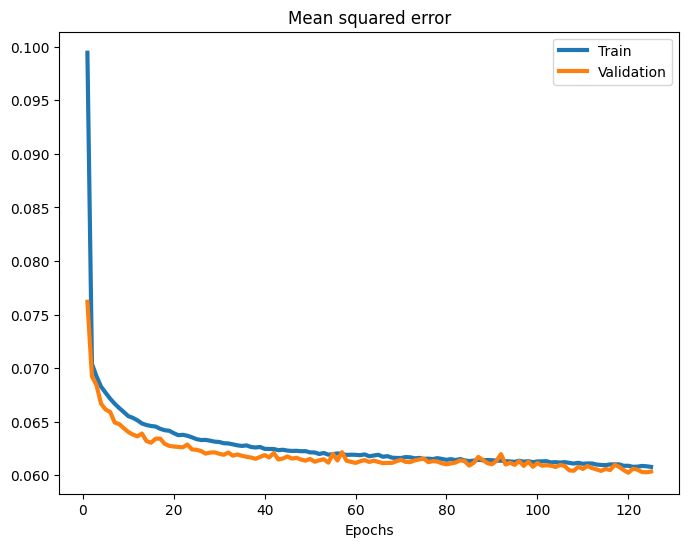

Training MSE = 0.24654792323132316
Validation MSE = 0.2456595511074541


In [18]:
def model_analysis(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.title("Mean squared error")
    sns.lineplot(x=epochs, y=train_loss, label="Train", linewidth=3)
    sns.lineplot(x=epochs, y=val_loss, label="Validation", linewidth=3)
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()

    print(f"Training MSE = {np.sqrt(train_loss[-1])}")
    print(f"Validation MSE = {np.sqrt(val_loss[-1])}")

model_analysis(history.history['loss'], history.history['val_loss'])

In [19]:
import gcsfs
# Create a GCS filesystem object using your project ID
fs = gcsfs.GCSFileSystem(project='autoencoder_census')

# Save the model locally
model_filename = "best_parameters_autoencoder.h5"
final_model.save(model_filename)



# Define the path to the file on GCS
gcs_model_path = "gs://autoencoder_census_models/best_parameters_autoencoder.h5"

# Open the local file in binary mode and upload its content to GCS
with open(model_filename, 'rb') as local_file:
    with fs.open(gcs_model_path, 'wb') as gcs_file:
        gcs_file.write(local_file.read())


In [20]:


# Store the hyperparameters and evaluation metrics in a dictionary
hyperparameters_dict = {"learning_rate": best_hps.get('learning_rate'),
                        "batch_size": best_hps.get('batch_size'),
                        "num_epochs": 10,
                        "loss": history.history['loss'][-1],
                        "val_loss": history.history['val_loss'][-1]}